# SARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

In [2]:
df = pd.read_csv("data.csv")
demand_df = df[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
demand_df['ds'] = pd.to_datetime(demand_df['ds'])
demand_df.head()

,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200


/var/folders/l1/b9500nvd2v57y822rhwp_f8c0000gp/T/ipykernel_39926/1173368332.py:4: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])


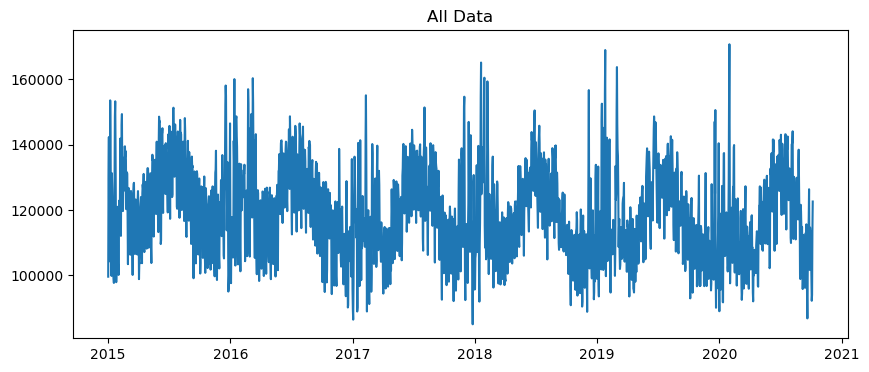

/var/folders/l1/b9500nvd2v57y822rhwp_f8c0000gp/T/ipykernel_39926/1173368332.py:10: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])


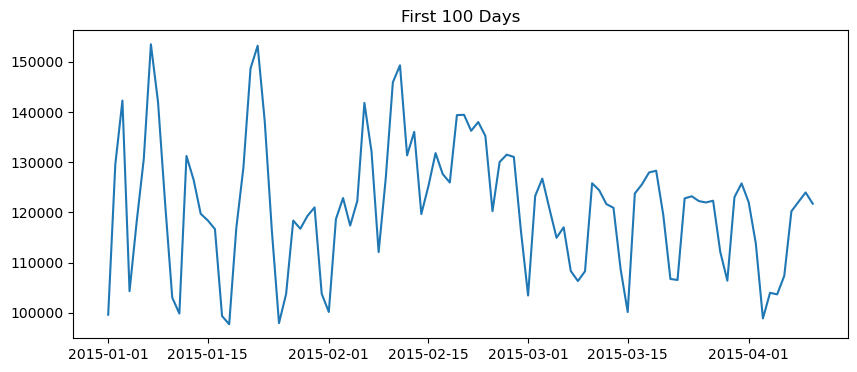

In [3]:
# Yearly seasonality - generally increases until June then decreases after
plt.figure(figsize=(10, 4))
plt.title("All Data")
plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])
plt.show()

# No evidence of weekly or monthly seasonality
plt.figure(figsize=(10, 4))
plt.title("First 100 Days")
plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])
plt.show()

/var/folders/l1/b9500nvd2v57y822rhwp_f8c0000gp/T/ipykernel_39926/1311622987.py:9: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='#1f76b4', label='Training Set')
/var/folders/l1/b9500nvd2v57y822rhwp_f8c0000gp/T/ipykernel_39926/1311622987.py:10: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(df_test['ds'].dt.to_pydatetime(), df_test["y"], color='#CDC7E5', label='Test Set')


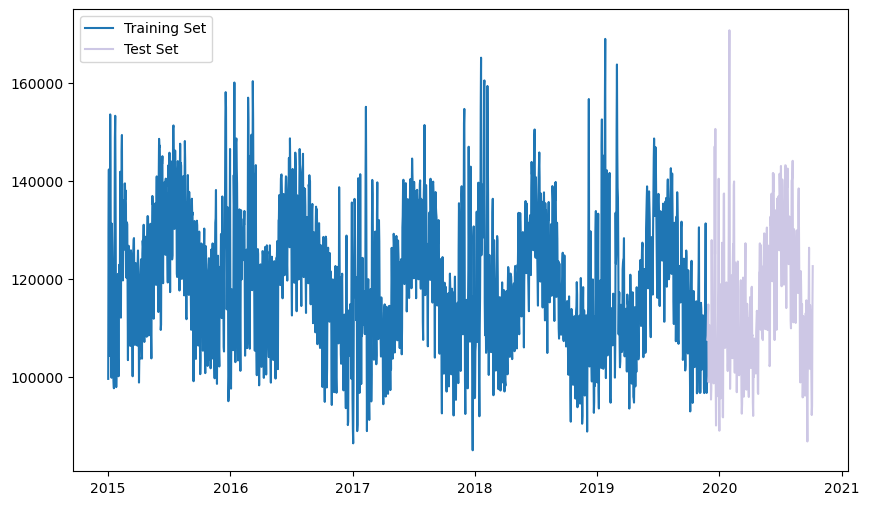

In [4]:
train_size = 0.85

df_train, df_test = demand_df[:int(len(demand_df)*train_size)], demand_df[int(len(demand_df)*train_size):]

# Visualize train and validation set
def train_valid_plot():
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='#1f76b4', label='Training Set')
    ax.plot(df_test['ds'].dt.to_pydatetime(), df_test["y"], color='#CDC7E5', label='Test Set')
    ax.legend()
    plt.show()
    
train_valid_plot()

In [5]:
# Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(df_train["y"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, # weekly frequency
                         start_P=0, 
                         seasonal=True, # set to seasonal
                         d=None, 
                         D=1, # order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [6]:
# Implement SARIMA with the optimal parameters
sarima_preds = []

for d in df_test['ds'].values:
    # Setting up dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Fit model + make predictions
    m_sarima = ARIMA(future['y'], order=(1,0,1), seasonal_order=(0, 1, 1, 7)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])

/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# Calculate performance metrics
y_true = df_test['y']
y_pred = sarima_preds

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test MAPE: {mape:.2f}%')

Test MSE: 63926230.47869301
Test RMSE: 7995.388075552869
Test MAE: 5643.918227194637
Test MAPE: 4.90%


# Prophet

In [29]:
# Instantiate and fit the Prophet model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(df_train)

21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Create a dataframe for future predictions including the test set dates
future = m.make_future_dataframe(periods=len(df_test), freq='D')

# Predict
forecast = m.predict(future)

In [31]:
# Extract predicted values and confidence intervals
preds = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(df_test))

# Merge predictions with the test set
df_test_merged = df_test.set_index('ds')
preds = preds.set_index('ds')
comparison_df = df_test_merged.join(preds[['yhat', 'yhat_lower', 'yhat_upper']])

In [32]:
# Calculate performance metrics
y_true = comparison_df['y']
y_pred = comparison_df['yhat']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the performance metrics
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test MAPE: {mape:.2f}%')

Test MSE: 91948557.65759587
Test RMSE: 9588.981054189015
Test MAE: 7369.730790878922
Test MAPE: 6.41%


/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


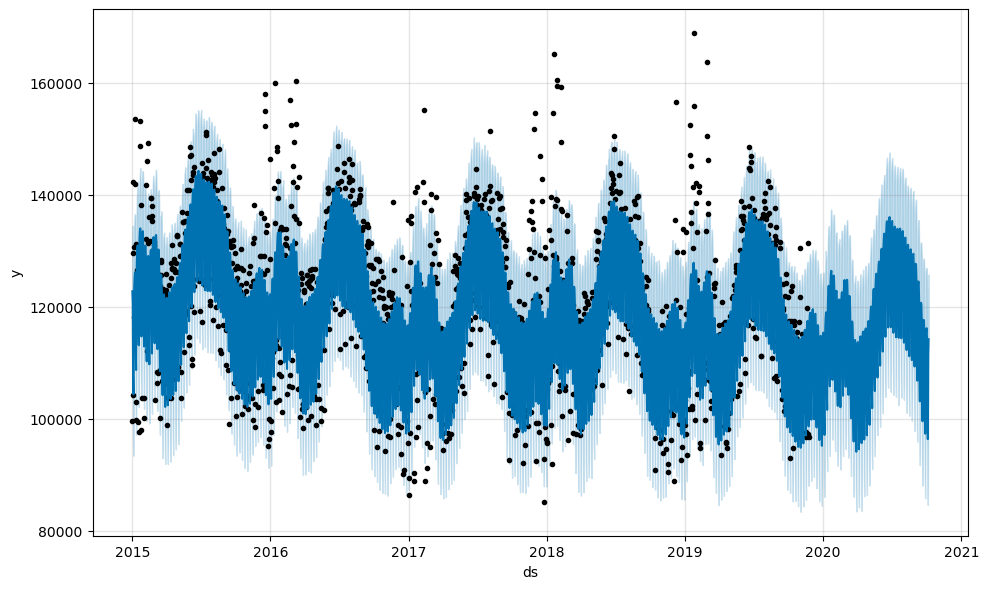

/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/tommasosalvatori/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects

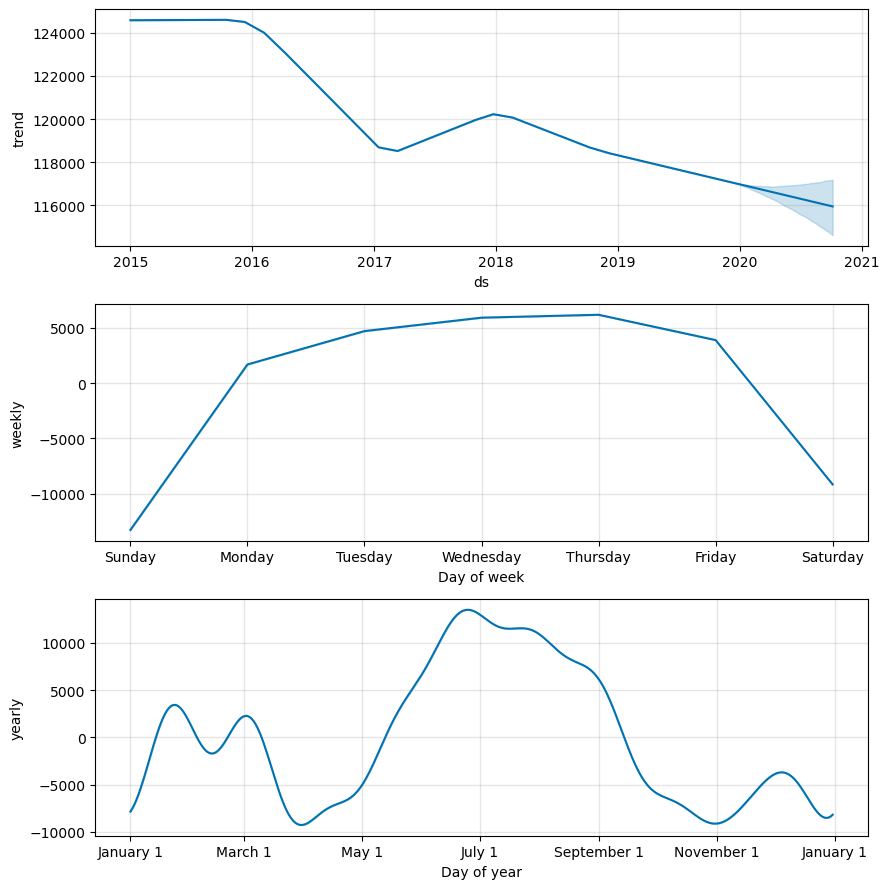

In [33]:
# Plot the forecast
fig1 = m.plot(forecast)
plt.show()

# Plot the forecast components
fig2 = m.plot_components(forecast)
plt.show()